# Machine Learning - Project 2:
# _Autoencoder for mathematical modeling of blood flow in a stenosis context_

## Context

In this project, we are going to analyze data derived from...

Our goals:
1. modeliser mathématiquement l’écoulement sanguin à l’aide de PDE dépendante de 2-3 paramètres physique
2. simuler l’écoulement par un code d’éléments fini ou similaire
3. générer beaucoup de solutions avec une grande nombre de paramètres différents. (Les 2-3, pris de façon aléatoire)
4. a. utiliser les solutions numérique pour établir un auto encoder qui au milieu n’ai que 2-5 hyper-paramètres libres  
b. quel erreur on obtient ? Est-ce possible de réduire le nombre d’hyper-paramètres ?
5. étudier s’il y a une rélation entre les 2-5 hyper-paramètre et les paramètres physique  
a. à l’aide de statistiques
5. b. à l’aide d’un DNN (différent de 4a)
6. (optionnel) faire un DNN entre l’input de 4a et output les paramêtres physique. Et/ou l’inverse.
7. Discussion et conclusions 

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Pickle](#pickle)

[4. Autoencoder](#autoencoder)

### Imports  <a name="1imports"></a>

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
from autoencoder import *
from crossvalidation import *
import _pickle as cPickle
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)
np.random.seed(1)
seed = 1

## 1. Data exploration  <a name="data_exploration"></a>

### Pathways <a name="1pathways"></a>

In [2]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_middle_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_middle_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [3]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [4]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (964075, 110)
Our input array Uy is of shape: (964075, 110)
Printing a row of Ux: 
 [0.07843621 0.31118352 0.68245424 1.15863002 1.69435217 2.2377946
 2.73607737 3.14059293 3.41183529 3.52330289 3.63726074 3.7439734
 3.84549407 3.94281205 4.03640323 4.12650964 4.2132592  4.29672103
 4.37693287 4.45391539 4.52767992 4.59823263 4.6655769  4.72971455
 4.79064658 4.84837353 4.90289569 4.95421322 5.00232621 5.04723472
 5.08893877 5.12743839 5.16273359 5.19482437 5.22371075 5.24939272
 5.2718703  5.29114348 5.30721227 5.32007667 5.32973668 5.33619229
 5.33944353 5.33997115 5.33936904 5.33787084 5.33552701 5.33235975
 5.32837974 5.3235924  5.31800058 5.31160582 5.30440894 5.29641041
 5.28761047 5.27800926 5.26760686 5.25640331 5.24439864 5.23159284
 5.21798594 5.20357794 5.18836883 5.17235862 5.15554731 5.13793491
 5.1195214  5.1003068  5.0802911  5.05947431 5.03785642 5.01543743
 4.99221734 4.96819616 4.94337388 4.9177505  4.89132603 4.86410046
 4.8360738  4.8

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated 25 simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [5]:
positions =5509 #We know it from the matlab code
times = Ux.shape[1]
simulations = int(Ux.shape[0]/positions)
print("We ran ", simulations, "simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)")
print("1 simulation calculate the velocities of the blood flow at ", positions, " different positions and at ", times, " different times")

We ran  175 simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)
1 simulation calculate the velocities of the blood flow at  5509  different positions and at  110  different times


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [6]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are no None values so we can start direclty preprocess our datasets.

ADDITIONAL IDEAS FOR PREPROCESSING
- remove columns with 0 std dev?
- standardization?

Let's sample our data points into the following ratios : 

In [7]:
ratio_pts = 0.01
ratio_time = 1

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(9625, 110) (9625, 110)


In [8]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from ', 5509, ' positions to ', new_Nu, ' positions')
print('With the sampling we got from ', 110, ' time steps to ', new_Nt, ' time steps')

With the sampling we got from  5509  positions to  55  positions
With the sampling we got from  110  time steps to  110  time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery :

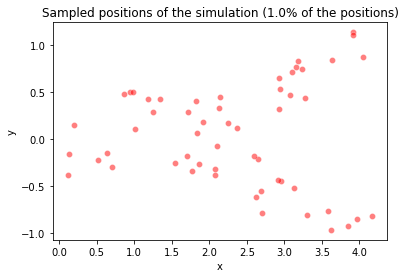

In [9]:
plot_sampled_coord(new_inds) 

In [10]:
print(new_Ux)

[[0.06598187 0.25670229 0.55084151 ... 2.51511171 2.47896831 2.44227292]
 [0.01822349 0.06614118 0.13306091 ... 0.49577011 0.48856679 0.48125408]
 [0.06441595 0.25109322 0.5398679  ... 2.481933   2.44626963 2.41006156]
 ...
 [0.0680136  0.26761562 0.58127622 ... 2.85725826 2.8164228  2.77496189]
 [0.06685035 0.26296953 0.57104399 ... 2.80158018 2.76153202 2.72087054]
 [0.07571559 0.29995296 0.65629618 ... 3.4415466  3.39267592 3.34305416]]


Let's flatten our matrices into a single matrix with dimensions $(N_s, (2 N_u N_t))$. For each simulation, the x and y speed coordinates are compressed to the following 1D matrix:

$$
\mathbf{M_{1D}}
=
\begin{bmatrix}
\vdots \\
u_{x}^{(0)} \\
\vdots \\
u_{y}^{(0)} \\
\vdots \\
u_{x}^{(1)} \\
\vdots \\
u_{y}^{(1)} \\
\vdots \\
u_{x}^{(N_t - 1)} \\
\vdots \\
u_{y}^{(N_t - 1)} \\
\vdots 
\end{bmatrix}
$$



In [11]:
flattened_array = flatten(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(175, 12100)

Let's make a sanity check that the dimension of 1 datapoint is indeed ${2 * new_{N_t} * new_{N_u}}$.

In [12]:
assert flattened_array.shape[1] == 2*new_Nt*new_Nu

print(2*new_Nt*new_Nu)

12100


## 3. Pickle  <a name="pickle"></a>

To avoid the loading and processing steps each time we open the notebook, we will save the processed matrix "flattened_array" using pickle : 

In the following cell, we will create pickles for every subsampled data according to the ratios_pts and the ratios_t :

In [14]:
ratios_pts = [0.1, 0.05, 0.02]
ratios_t = [0.5, 0.25, 0.1]

create_subsamples(Ux, Uy, ratios_pts, ratios_t, name_file='middle_small')

#### Start from here if you the pickle file already exist in your data folder

Change only the following cell to change the name of the file you want to open :

In [2]:
ratios = [0.1, 0.1]
size = ['very_small', 'small', 'large']

name = 'processed_'+str(size[0])+'_'+str(ratios[0])+'_'+str(ratios[1])

print('name of the file you want to read : ', name)

name of the file you want to read :  processed_very_small_0.1_0.1


In [3]:
flattened_array  = cPickle.load(open("data/pickle/"+str(size[0])+"/"+name, "rb"))

In [4]:
print(flattened_array)

[[ 5.83595480e-02  1.52145667e-02  5.22789790e-02 ...  1.30250813e+00
   1.75962902e-02  3.29361219e-03]
 [ 6.44804449e-02  1.52124591e-02  6.16749165e-02 ...  1.12612391e+00
   2.15122489e-02  1.69013092e-03]
 [ 1.48231783e-01  2.60291062e-02  1.49105089e-01 ...  1.52711420e+00
  -1.40045143e-02 -3.46626137e-02]
 ...
 [ 9.96757422e-02  1.29199047e-02  8.22345984e-02 ...  3.16453290e+00
   5.01625470e-02 -2.68016815e-03]
 [ 1.85973493e-01  4.85260306e-02  1.79182342e-01 ...  3.10024150e+00
   3.40756151e-02 -1.95397704e-02]
 [ 1.65302611e-01  3.80143624e-02  1.64879092e-01 ...  1.77349641e+00
   2.60974691e-02  2.09641184e-02]]


##### Final step : split train/test

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [5]:
x_train, x_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = x_train, x_test

print(x_train.shape)
print(x_test.shape)

(22, 12100)
(3, 12100)


## 4. Feed-forward auto-encoder  <a name="autoencoder"></a>

#### Parameters tuning

Find the best learning rate of our model using cross-validation :

In [31]:
# define network parameters
learning_rates =[0.1, 0.05, 0.01, 0.005, 0.001]
epochs= 2 #50
input_size=x_train.shape[1]
k_folds = 5
dataset_name = "very_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Learning rate =  0.1

Performance of 5 fold cross validation: 
Average Training Error: 275634.460 	 Average Test Error: 280156.391
 
Learning rate =  0.05

Performance of 5 fold cross validation: 
Average Training Error: 1.009 	 Average Test Error: 0.996
 
Learning rate =  0.01

Performance of 5 fold cross validation: 
Average Training Error: 0.976 	 Average Test Error: 0.975
 
Learning rate =  0.005

Performance of 5 fold cross validation: 
Average Training Error: 0.603 	 Average Test Error: 0.571
 
Learning rate =  0.001

Performance of 5 fold cross validation: 
Average Training Error: 0.988 	 Average Test Error: 0.987
 

Best learning rate is  0.005  with a best error of :  0.5706693245346489



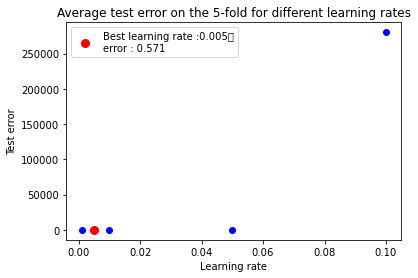

In [32]:
best_result, best_lr = tuning_lr(x_train, k_folds, input_size, epochs, criterion, learning_rates,  dataset_name_=dataset_name)

Find the best number of neurons in the latent space (neurons in the "middle layer of the auto-encoder") in the auto-encoder (which is actually the dimension of the compressed data) : 

In [33]:
# define network parameters
lr = best_lr # from above
epochs= 1 #50
input_size=x_train.shape[1]
k_folds = 5
number_neurons = [3, 5] #[3, 5, 6, 8, 10]
dataset_name = "very_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Number of neurons =  3

Performance of 5 fold cross validation: 
Average Training Error: 0.857 	 Average Test Error: 0.849
 
Number of neurons =  5

Performance of 5 fold cross validation: 
Average Training Error: 0.889 	 Average Test Error: 0.891
 
The results obtained for the number of latent neurons tested are the following : [0.8485467306247962, 0.8906018940955327].
The best average test error obtained is 0.8485467306247962, and it is obtained with 3 neurons in the latent layer.


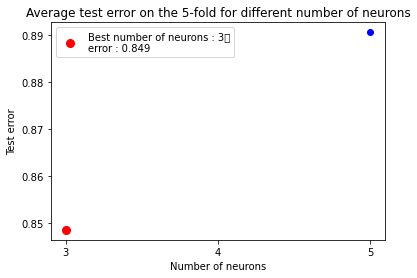

In [34]:
best_result, best_neurons_nb = tuning_latent_layer(x_train, k_folds, input_size, epochs, criterion, lr, number_neurons,  dataset_name_=dataset_name)

#### Let's try with the tuned parameters and see how it goes along the epochs

In [ ]:
# define network parameters
learningRate= best_lr
epochs=50
input_size=x_train.shape[1]
k_folds = 5
neuron_ = best_neurons_nb

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss() 

In [ ]:
Kfold(x_train, k_folds, input_size, epochs, criterion, learningRate, neuron=neuron_)

#### Quality of the compression on the test set using the tuned parameters :

We will now train and test our auto-encoder for different sample size of our initial dataset. To do so we will do a batch processing and store the final train and test errors. See the report to see the nice comparison table :

In [ ]:
import glob
import os 
import _pickle as cPickle

dataset = 'very_small'
file_location = os.path.join('data', 'pickle', dataset, '*')
filenames = glob.glob(file_location)
i=0 


# define the model
best_lr = 0.1
best_neurons = 5
epochs=50
input_size=filenames[0].shape[1]
criterion = nn.MSELoss() 

model = Autoencoder(input_size, best_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=1e-5)

test_errors = []
train_errors = []

for f in filenames:
    #Load the data
    x  = cPickle.load(open(f, "rb"))
    
    #Split
    x_train, x_test = train_test_split(x, test_size=0.1, random_state=seed)
    y_train, y_test = x_train, x_test
    
    #Training

    # loop over the epochs
    for epoch in range(epochs):
        # train the model 
        train_loss=train_epoch(x_train, model, criterion, optimizer)
        # compute the relative training error
        train_error = valid_epoch(x_train, model)
        # compute the relative test error
        test_error=valid_epoch(x_test, model)
    
    #Save the last epoch train and test errors
    test_errors.append(test_error)
    train_errors.appedn(train_error)

In [ ]:
#Save in pickles

name = "train_errors_" + dataset
cPickle.dump( train_errors , open( name, "wb" ) )
name = "test_errors_" + dataset
cPickle.dump( test_errors , open( name, "wb" ) )

## 4. Passer en 2D 

Instead of flattenning our initial dataset into a colummn vector for each simulation, we split it into a 2D matrix for each simulation such as the following:

$$
\mathbf{M_{2D}}
=
\begin{bmatrix}
\vdots & \vdots & \vdots & \vdots \\
u_{x}^{(0)} & u_{x}^{(1)} & \cdots &
u_{x}^{(N_t - 1)} \\
\vdots & \vdots & \ddots & \vdots \\
u_{y}^{(0)} & u_{y}^{(1)} & \cdots &
u_{y}^{(N_t - 1)} \\
\vdots & \vdots & \vdots & \vdots
\end{bmatrix}
$$

In [16]:
flattened_array = flatten_2d(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 1100, 110)

## 5. Passer en 4D

In [11]:
flattened_array_4d = flatten_4d(new_Ux, new_Uy, ratio_pts)
flattened_array_4d.shape

IndexError: index 55 is out of bounds for axis 1 with size 55

In [ ]:
flattened_array_4d = normalize(flattened_array_4d)

In [ ]:
x_train, x_test = train_test_split(flattened_array_4d, test_size=0.1, random_state=seed)

In [ ]:
import h5py

In [ ]:
hf = h5py.File('trainset.h5', 'w')
hf.create_dataset('dataset_1', data=x_train)

In [ ]:
hf = h5py.File('testset.h5', 'w')
hf.create_dataset('dataset_1', data=x)

## 6. Discussion & conclusion